# **SAMPLING STORM CENTERS** #

#### Objectives: ####
+ Getting a grip on the spatial sampling of storm centres
+ Recipes for spatial plotting (via [Numpy](https://numpy.org/doc/stable/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/getting_started/index.html))

---

STORM samples storm centres following the complete spatial randomness (CSR) framework implemented throughout the [Pointpats](http://pysal.org/pointpats/) library.
Please check out the aforementioned reference, which offers more in-depth mathematical details.
For now, suffice to say that the approach presented below allows a faster generation of random samples following a [Poisson (Point) Process](https://en.wikipedia.org/wiki/Poisson_point_process) inside a (delimited) region (e.g., $\lambda$-conditioned CSR, where $\lambda$ represents the intensity of events).

<span style="color:HotPink">*Note: Unlike the PDF-parameterization shown in notebook [one_](./one_.ipynb), the spatial parameters/constants displayed here do represent the HAD (Horn-of-Africa Drylands).*</span>

<span style="color:RoyalBlue">Most of the variables shown in caps (constraining the modeling and performance of STORM) can be found and set up in the [parameters.py](../parameters.py) module.</span>

---

The sampling and processing of storm centres is done by STORM through the functions: SCENTRES, SHP_REGION, and SHP_REGION_GRID of the [rainfall.py](../rainfall.py) module.

---

### STORM PARAMETERS ###
<a id='pars'></a>

In [43]:
# catchment shape-file in WGS84
SHP_FILE = "../model_input/HAD_basin.shp"
BUFFER = 21097.5  # in meters! -> buffer distance (out of the HAD)

# OGC-WKT for HAD [taken from https://epsg.io/42106]
WKT_OGC = (
    'PROJCS["WGS84_/_Lambert_Azim_Mozambique",'
    'GEOGCS["unknown",'
    'DATUM["unknown",'
    'SPHEROID["Normal Sphere (r=6370997)",6370997,0]],'
    'PRIMEM["Greenwich",0,'
    'AUTHORITY["EPSG","8901"]],'
    'UNIT["degree",0.0174532925199433,'
    'AUTHORITY["EPSG","9122"]]],'
    'PROJECTION["Lambert_Azimuthal_Equal_Area"],'
    'PARAMETER["latitude_of_center",5],'
    'PARAMETER["longitude_of_center",20],'
    'PARAMETER["false_easting",0],'
    'PARAMETER["false_northing",0],'
    'UNIT["metre",1,'
    'AUTHORITY["EPSG","9001"]],'
    'AXIS["Easting",EAST],'
    'AXIS["Northing",NORTH],'
    'AUTHORITY["EPSG","42106"]]'
)

## <u>RANDOM SAMPLING OF POINTS INSIDE A (SPATIAL) WINDOW</u> ##

The exercise below samples random points (storm centres) within a buffer of the [Shapefile](https://en.wikipedia.org/wiki/Shapefile) (SHP) of the HAD.

In [45]:
# first get rid of some (potential and) unwanted warnings
import warnings

# supressing warnings by "message"

# https://github.com/slundberg/shap/issues/2909
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
# # https://stackoverflow.com/a/9134842/5885810
# warnings.filterwarnings(
#     "ignore",
#     message="You will likely lose important projection "
#     "information when converting to a PROJ string from another format",
# )

In [46]:
# loading libraries
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj as pp
from cartopy.mpl.ticker import (
    LatitudeFormatter,
    LatitudeLocator,
    LongitudeFormatter,
    LongitudeLocator,
)
from matplotlib.ticker import FixedLocator
from pointpats import random as pran

We read the SHP, and assume it comes in the (familiar) geographic coordinate system ([GCS](https://en.wikipedia.org/wiki/Geographic_coordinate_system)) known as [WGS84](https://epsg.io/4326).
Then, we must re-project it a local (planar) system to carry out the sampling.
In this case the local coordinate reference system (CRS) is the one stored in the [**WKT_OGC**](#crs-ref) variable (as [OGC WKT](https://gdal.org/tutorials/wktproblems.html) format).

In [47]:
# read the SHP
wtrwgs = gpd.read_file(SHP_FILE)

# transform it into EPSG:42106 & make the buffer  -> the EPSG:42106 code is nowhere supported!!
# https://gis.stackexchange.com/a/328276/127894     (geo series into gpd)
wtrshd = wtrwgs.to_crs(crs=WKT_OGC)  # //epsg.io/42106.wkt
BUFFRX = gpd.GeoDataFrame(geometry=wtrshd.buffer(BUFFER))  # .to_crs(epsg=4326)

# how does the buffer (or any other SHP for that matter) look like?
print(BUFFRX)

                                            geometry
0  POLYGON ((1496219.170 -52287.662, 1496224.965 ...


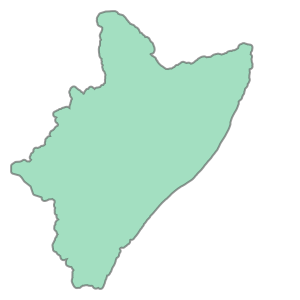

In [48]:
# object to be passed
BUFFRX.geometry.xs(0)

Now we sample the centres.

In [49]:
CENTS = pran.poisson(BUFFRX.geometry.xs(0), size=666)

# how do they look like?
print(CENTS)

[[2107635.60188592  887475.20622038]
 [2965670.71223349  563437.15605768]
 [1615476.4950927   -61968.17485462]
 ...
 [2816194.45931149 -200803.17483746]
 [2962802.42275221  305470.82533051]
 [2860973.45535466  274386.0435137 ]]


### Visualization (via Matplotlib) ###

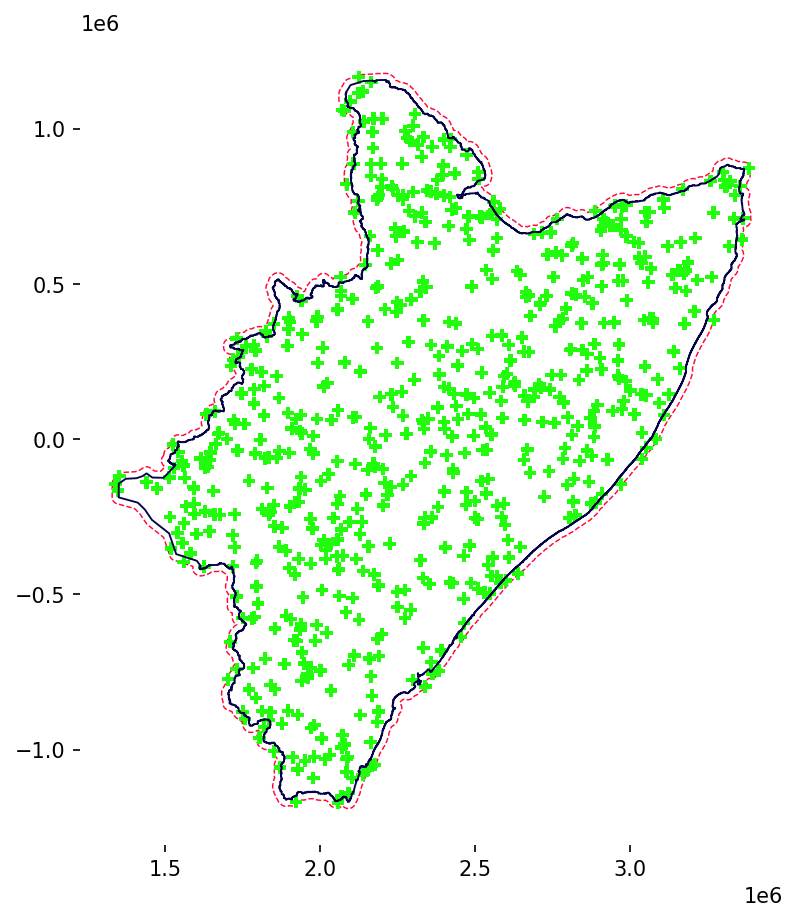

In [50]:
fig = plt.figure(figsize=(7, 7), dpi=150)

# remove axes and spines
ax = plt.axes()
for spine in ax.spines.values():
    spine.set_edgecolor(None)

# plot the buffer
BUFFRX.plot(
    edgecolor="xkcd:neon red",
    alpha=1.0,
    zorder=2,
    linewidth=0.7,
    ls="dashed",
    facecolor="None",
    ax=ax,
)
# plot the centres (the 2D numpy)
plt.scatter(
    CENTS[:, 0],
    CENTS[:, 1],
    marker="P",
    c="xkcd:electric green",
    s=37,
    edgecolors="none",
    zorder=3,
)
# and overlay the catchment
wtrshd.plot(
    edgecolor="xkcd:night blue",
    alpha=1.0,
    zorder=4,
    linewidth=0.9,
    ls="solid",
    facecolor="None",
    ax=ax,
)

plt.show()

### Visualization (via Cartopy) ###

<span style="color:HotPink">*Note: The use of Proj strings is being higly discouraged (check [this](https://gis.stackexchange.com/questions/374508/spproj4string-equivalent-in-the-proj6-framework/374968#374968) or [this](https://inbo.github.io/tutorials/tutorials/spatial_crs_coding/) out).*</span>

Cartopy allows some few [projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html) defined mainly? via [Proj](https://proj.org/en/9.3/) strings.
[Pyproj](https://pyproj4.github.io/pyproj/stable/) allows the conversion from WKT to Proj strings; something like...

In [51]:
# retrieving a Proj from WKT
crs_had = pp.CRS.from_wkt(WKT_OGC).to_proj4()

# how does it look like?
print(crs_had)

+proj=laea +lat_0=5 +lon_0=20 +x_0=0 +y_0=0 +ellps=sphere +units=m +no_defs +type=crs


The above string seems to be just fine (despite the Warning message --if any at all--).
Nevertheless, if you try that variable/string in the code/visualization below, it would give you lots of headaches.
Therefore, the alternative is to manually create the HAD CRS (from the WKT we already have).

In [52]:
# manual set up of the HAD CRS
crs_alt = ccrs.LambertAzimuthalEqualArea(
    central_latitude=5,
    central_longitude=20,
    false_easting=0,
    false_northing=0,
    globe=None,
)

# how does it look like?
print(crs_alt)

+proj=laea +ellps=WGS84 +lon_0=20 +lat_0=5 +x_0=0 +y_0=0 +no_defs +type=crs


<span style="color:RoyalBlue">*You'd agree that it looks almost the same as the first one, right?*</span>

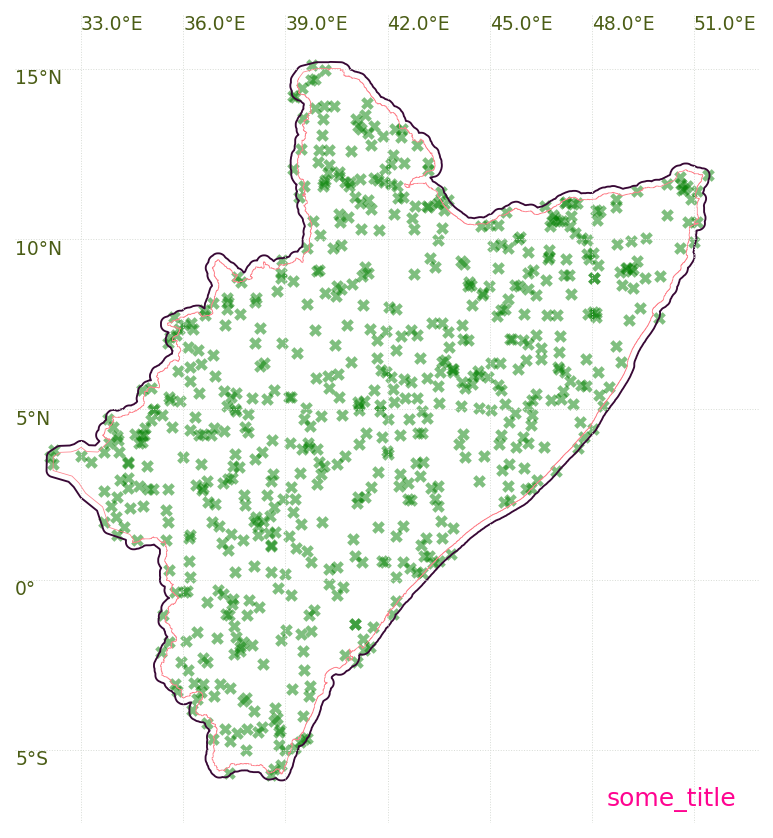

In [54]:
# some more parameters...
lims = BUFFRX.bounds.iloc[0].to_dict()
difs = dict(x=abs(lims["maxx"] - lims["minx"]), y=abs(lims["maxy"] - lims["miny"]))
offs = 0.05  # in percentage

# the plot starts here
fig = plt.figure(figsize=(7, 7), dpi=150)
# fig.tight_layout(pad=0)  # doesn't do nothing here (maybe when xporting to PDF?)

# ax = plt.axes(projection=ccrs.epsg(42106))  # -> this EPSG code doesn't officially exist!
# ax = plt.axes(projection=ccrs.Projection( crs_had ))  # -> this gives you headaches
# ax = plt.axes( projection=car_crs )  # -> Cartopy didn't create grid for this proj
ax = plt.axes(projection=ccrs.PlateCarree())  # -> this means WGS84

ax.set_aspect(aspect="equal")
# remove spines and labels
ax.spines["geo"].set_visible(False)
ax.xlabels_top = False
ax.ylabels_right = False

# this IF block is to plot Grid-Lines (which can only be done for WGS84
# 'eqc' potentially means that the system is PlateCarree [otherwise the following block won't work']
if ax.projection.proj4_params["proj"] == "eqc":
    # gridlines and some labels out
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.47,
        color="xkcd:light grey",
        linestyle="dotted",
        alpha=1.0,
    )
    gl.right_labels = False
    gl.bottom_labels = False
    # format of the tick labels
    gl.xformatter = LongitudeFormatter(
        direction_label="inout",
        degree_symbol="°",
        number_format=".1f",
        transform_precision=1e-08,
        dms=False,
        auto_hide=False,
    )
    gl.yformatter = LatitudeFormatter(
        direction_label="inout",
        degree_symbol="°",
        number_format=".0f",
        transform_precision=1e-08,
        dms=False,
        auto_hide=False,
    )
    gl.ylocator = LongitudeLocator(nbins=5, integer=True)
    # gl.ylocator = FixedLocator( [-4, 0, 4, 8, 12, 16] )  # for instance
    # label parameters
    gl.xlabel_style = {
        "size": 9,
        "color": "xkcd:army green",
        "weight": "light",
        "ha": "left",
    }  # 'visible':True
    gl.ylabel_style = {
        "size": 9,
        "color": "xkcd:army green",
        "weight": "light",
        "va": "top",
    }
    gl.xpadding = -0.1
    gl.ypadding = -0.1

# define some extent
ax.set_extent(
    [
        lims["minx"] - difs["x"] * offs,
        lims["maxx"] + difs["x"] * offs,
        lims["miny"] - difs["y"] * offs,
        lims["maxy"] + difs["y"] * offs,
    ],
    crs=crs_alt,
)

# add layers
ax.add_geometries(
    BUFFRX.geometry.xs(0),
    edgecolor="xkcd:eggplant",
    facecolor="none",
    linewidth=0.9,
    zorder=2,
    crs=crs_alt,
)
ax.add_geometries(
    wtrshd.geometry.xs(0),
    edgecolor="xkcd:blush pink",
    facecolor="none",
    linewidth=0.37,
    zorder=4,
    crs=crs_alt,
)
# plot the centres
plt.scatter(
    CENTS[:, 0],
    CENTS[:, 1],
    marker="X",
    s=37,
    edgecolors="red",
    lw=0.003,
    alpha=0.5,
    c="green",
    transform=crs_alt,
)

# add time.stamp
ax.text(
    0.97,
    0.03,
    "some_title",
    color="xkcd:electric pink",
    fontsize=12,
    fontweight="normal",
    horizontalalignment="right",
    va="center",
    clip_on=True,
    transform=ax.transAxes,
)

plt.show()

# # use these for exporting and cleaning [don't forget to comment out "plt.show()"!!]
# plt.savefig(
#     "two_.pdf", bbox_inches="tight", pad_inches=0.02, facecolor=fig.get_facecolor()
# )
# plt.close()
# plt.clf()

<span style="color:MediumSeaGreen">You're encouraged to: 1) Test/bring your own SHP into the [**SHP_FILE**](#crs-ref) variable (mind the [**WKT_OGC**](#crs-ref)!)</span>